# Calculate and save footprints over entire period.

* ## Intersect with a map of the basin 

* ### Query given footprints and calculate contours

In [1]:
%matplotlib notebook
# %matplotlib inline
import sys
import os
import time
import numpy as np

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, shape

import rasterio
from rasterio import features
from rasterio.transform import from_origin
from matplotlib import pyplot as plt

from geopandas import GeoDataFrame
from datetime import datetime


import datetime
# from functools import partial
# from multiprocessing import Pool
from rasterio.plot import show

# import ProgressBar as prb

import Footprint_Processing as FP

import importlib
importlib.reload(FP)

<module 'Footprint_Processing' from 'C:\\Users\\wesle\\Illisarvik_Processing\\Footprint_Processing.py'>

# Date Range & Paramters

In [42]:
FirstRun = True
DateRange=['2016-7-23 12:00:00','2016-7-24 23:30:00']  ## Subset for testing
Query=[['2016-7-23 12:30:00','2016-7-24 19:00:00','Test1'],
      ['2016-7-23 12:30:00','2016-7-23 13:30:00','Test2']]
Axis = 40
rs = [50,75,90]
dx = 1
XY = [516097.33,7707931.12]
nx = 1000 
fp_params={'dx':dx,'nx':nx,'rs':rs}
west = XY[0]-(nx*dx)/2
north = XY[1]+(nx*dx)/2

RasterPath = 'C:/Illisarvik/Footprints/'
DataName = 'FilteredData2018-04-23.csv'

Jobs = {}
for query in Query:
    index = pd.date_range((query[0]),(query[1]),freq='30T')
    Jobs[query[2]]=index


## Read & filter the data, initialize the Basin Map

In [ ]:
Data = pd.read_csv(DataName)
Data = Data.set_index(pd.DatetimeIndex(Data.datetime))
Data['Run']=0
Data.loc[((np.isfinite(Data['Zo'])==True)&np.isfinite(Data['co2_flux'])==True)&(Data['u*']>.1)&
         (Data.index>DateRange[0])&(Data.index<DateRange[1])&              # Run a subset for teting
         ((Data['wind_dir']<Axis+180-30)|(Data['wind_dir']>Axis+180+30)),
         ['Run']]=1
Data=Data.reset_index(drop=True)
Dates = Data['datetime']
Run = Data.loc[Data['Run']==1].reset_index().drop(['index'],axis=1)
Runs = Run.shape[0]

Basin = gpd.read_file('Vegetation1.2.shp')
Basin['Area'] = Basin.area
Basin['Dkey'] = 1
BasinBounds = Basin.dissolve(by='Dkey').geometry[1]  

shapes = ((geom,value) for geom,value in zip(Basin['geometry'],Basin['Code']))

west = XY[0]-(nx*dx)/2
north = XY[1]+(nx*dx)/2
Transform = from_origin(west,north,dx,dx)

with rasterio.open('Basin_Image.tif','w',driver='GTiff',width = nx+1, height = nx+1,count = 1,dtype=np.float64,
                   affine = Transform,crs = ({'init': 'EPSG:32608'})) as out:
    out_arr = out.read(1)
    params = out.profile
    del params['transform']
    Basin_Image = features.rasterize(shapes=shapes,fill = 100,out = out_arr,transform = out.affine,default_value=0)
#     print(out.affine[0])
    out.write(Basin_Image,1)
    plt.figure()
with rasterio.open('C:/Illisarvik/Basin_Mosaic.tif','r') as out:
    show((out))

Basin.plot()


## Footprints

<IPython.core.display.Javascript object>


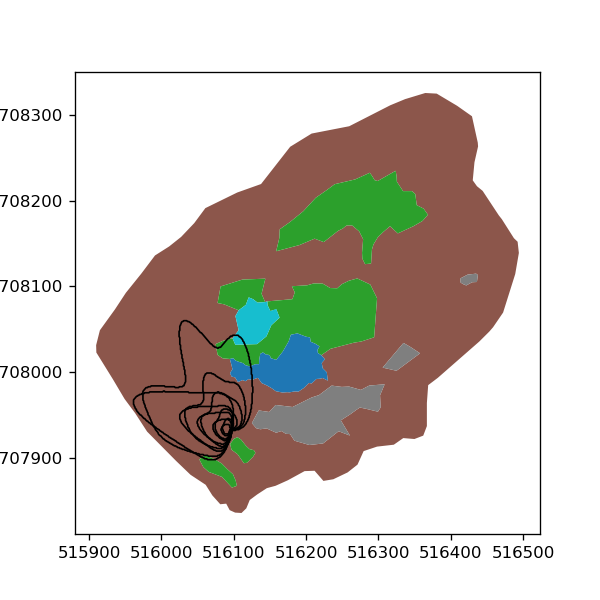

[||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] 100.0%
Test1:
[||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] 100.0%
Test2:
[||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] 100.0%


In [44]:
fig,ax=plt.subplots(1,1,figsize = (5,5))
Basin.plot(ax=ax,column = 'Name')
importlib.reload(FP)
FP_Data = FP.Calculate(RasterPath,Run,os.getcwd()+'/Basin_Image.tif',XY,Classes=Basin)
# print(FP_Data.Intersections)
Cont = FP.Contours(RasterPath,Jobs=Jobs,ax=ax)

## Generate contour

In [24]:

Copy = out_arr+0.0
FlatCopy = np.sort(Copy.ravel())[::-1]

Cumsum = np.sort(Copy.ravel())[::-1].cumsum()

d = {}
d['contour'] = []
geometry = list()
for r in [.25,.50,.70,.80,.90]:
    
    pct = FlatCopy[np.where(Cumsum < r)]
    Mask = out_arr+0.0
    Mask[Mask>=pct[-1]] = 1
    Mask[Mask<pct[-1]] = np.nan
    multipart = 'No'
    for shp, val in features.shapes(Mask.astype('int16'), transform=Transform):
        if val == 1:
            d['contour'].append(r)
            Poly = shape(shp)
            Poly = Poly.buffer(dx, join_style=1).buffer(-dx, join_style=1)
            Poly = Poly.buffer(-dx, join_style=1).buffer(dx, join_style=1)
            if multipart == 'No':
                geometry.append(Poly)
            else:
                Multi = []
                for part in geometry[-1]:
                    Multi.append(part)
                Multi.append(Poly)
                geometry[-1]=MulitPolygon(Multi)
            mulitpart = 'Yes'
df = pd.DataFrame(data=d)

geo_df = GeoDataFrame(df,crs={'init': 'EPSG:32608'},geometry = geometry)
geo_df['area'] =  geo_df.area 
geo_df.to_file('Climatology.shp', driver = 'ESRI Shapefile')
geo_df.plot(facecolor='None',edgecolor='black')

print('Finished!')
print(time.time()-Time)

IndexError: index -1 is out of bounds for axis 0 with size 0

## Intersect Function

In [5]:
# def Intersection():
    


SyntaxError: unexpected EOF while parsing (<ipython-input-5-0515eaad5caf>, line 2)

In [ ]:
i= 2133
print(Run['Zm'].iloc[i],Run['Zo'].iloc[i],Run['PBLH'].iloc[i],
                            Run['L'].iloc[i],Run['v_var'].iloc[i],Run['u*'].iloc[i],
                        Run['wind_dir'].iloc[i])
i= 1
print(Run['Zm'].iloc[i],Run['Zo'].iloc[i],Run['PBLH'].iloc[i],
                            Run['L'].iloc[i],Run['v_var'].iloc[i],Run['u*'].iloc[i],
                        Run['wind_dir'].iloc[i])
A = Run_Func(i,Run,fp_params)
print(A)